In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.ensemble import (
    BaggingRegressor,
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from mlxtend.evaluate import bias_variance_decomp

# Part A: Data Preprocessing and Baseline

## A.1: Data Load & Feature Engineeering

In [2]:
# Load the datasets
day_df = pd.read_csv('Bike Sharing Dataset/day.csv')
hour_df = pd.read_csv('Bike Sharing Dataset/hour.csv')

In [3]:
# Drop irrelevant columns from day.csv DataFrame
day_df = day_df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

# Drop irrelevant columns from hour.csv DataFrame
hour_df = hour_df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

In [4]:
# Concise summary including null counts and datatypes
print(day_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      731 non-null    int64  
 1   yr          731 non-null    int64  
 2   mnth        731 non-null    int64  
 3   holiday     731 non-null    int64  
 4   weekday     731 non-null    int64  
 5   workingday  731 non-null    int64  
 6   weathersit  731 non-null    int64  
 7   temp        731 non-null    float64
 8   atemp       731 non-null    float64
 9   hum         731 non-null    float64
 10  windspeed   731 non-null    float64
 11  cnt         731 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.7 KB
None


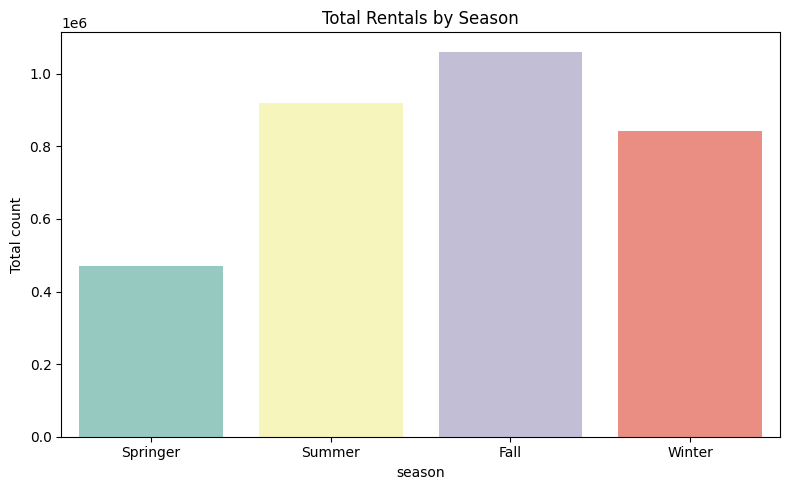

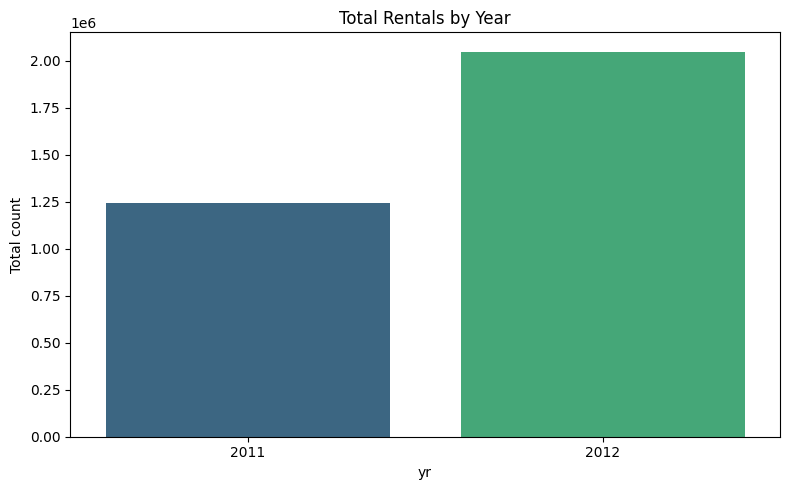

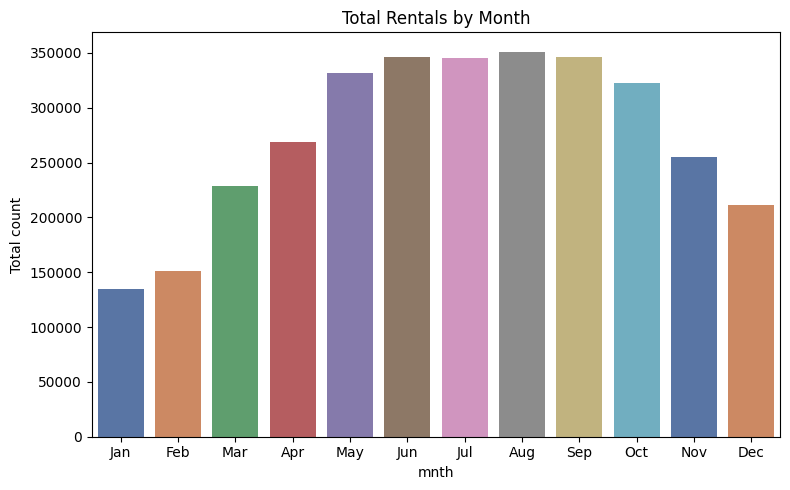

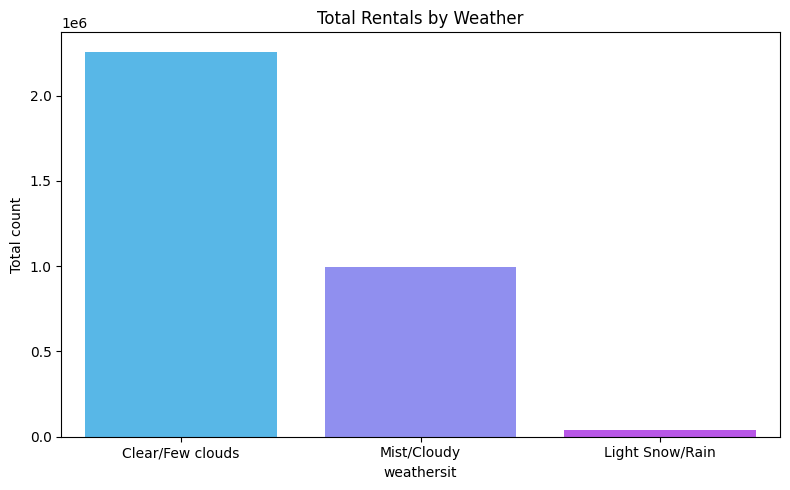

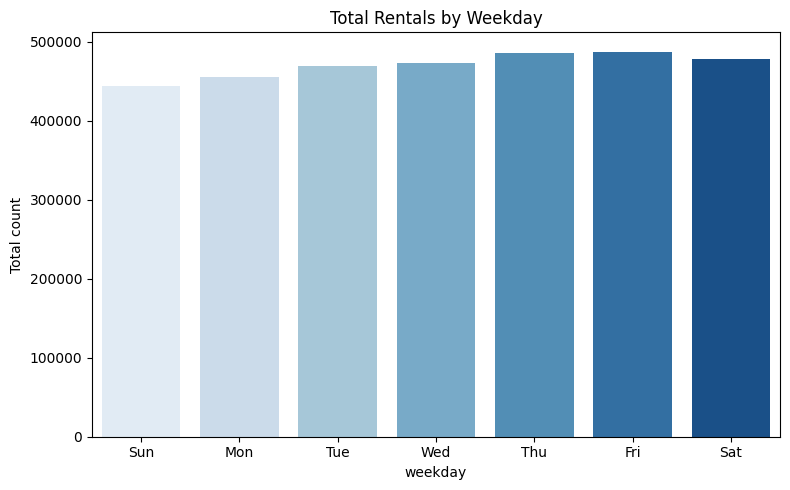

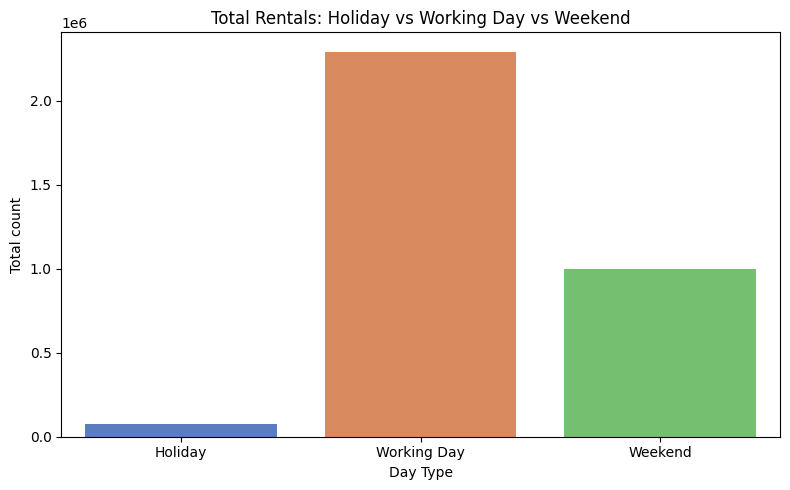

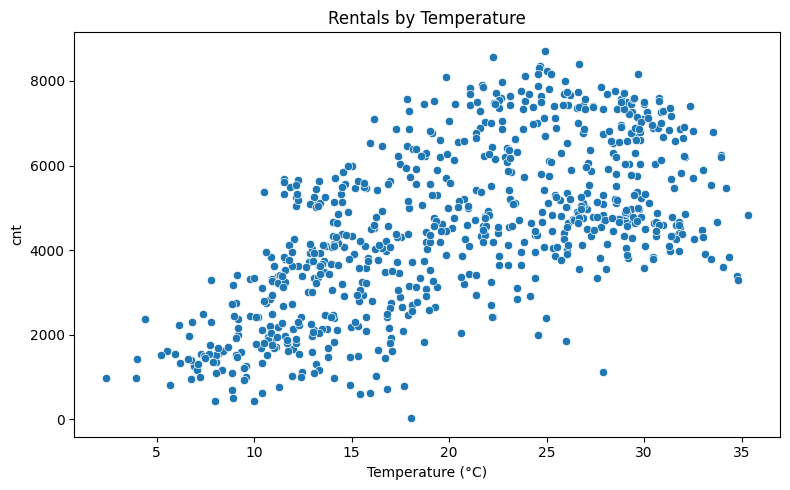

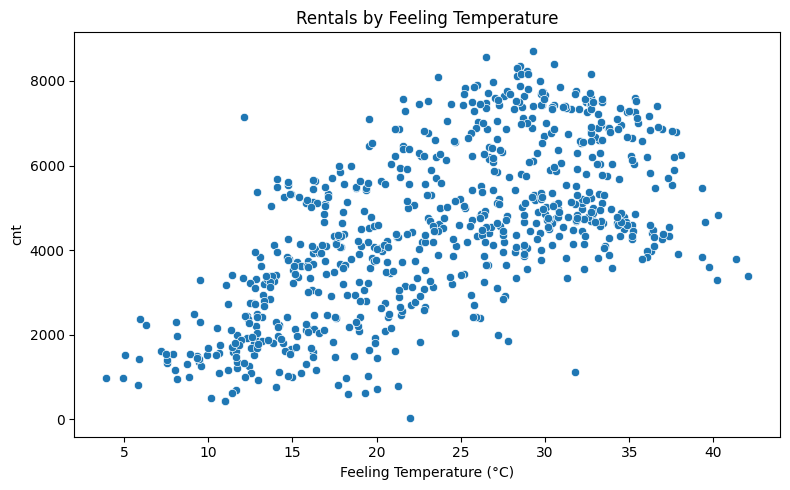

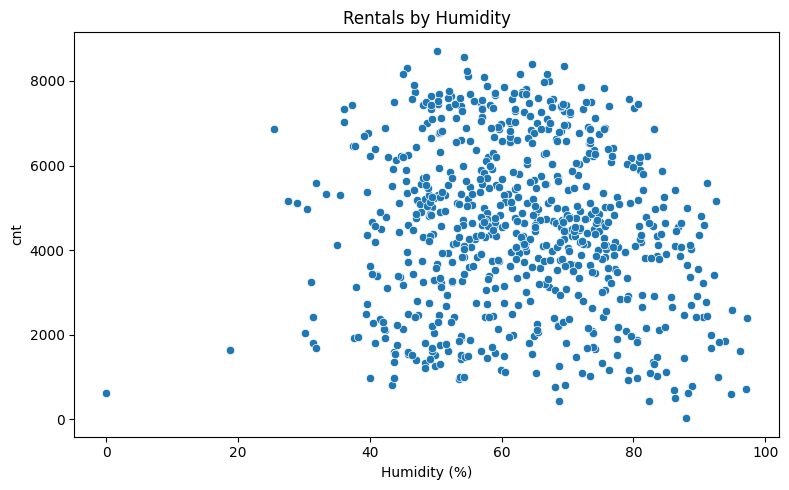

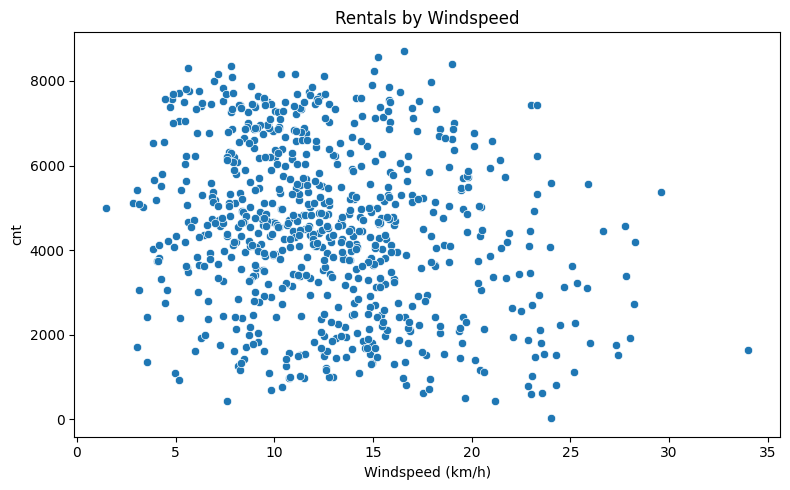

In [5]:
import warnings
warnings.filterwarnings("ignore")

# --- Mappings for better tick labels ---
season_labels      = {1: "Springer", 2: "Summer", 3: "Fall", 4: "Winter"}
yr_labels          = {0: "2011", 1: "2012"}
mnth_labels        = {i: name for i, name in zip(range(1,13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])}
weathersit_labels  = {1: "Clear/Few clouds", 2: "Mist/Cloudy", 3: "Light Snow/Rain", 4: "Heavy Rain/Snow+Fog"}
weekday_labels     = {i: w for i, w in enumerate(["Sun","Mon","Tue","Wed","Thu","Fri","Sat"])}
holiday_labels     = {0: "No Holiday", 1: "Holiday"}
workingday_labels  = {0: "Weekend/Holiday", 1: "Working Day"}

def plot_bar(day_df, col, labels, title, palette="Set2"):
    group = day_df.groupby(col)["cnt"].sum().reset_index()
    label_list = [labels.get(v, str(v)) for v in group[col].values]
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=col, y="cnt", data=group, palette=palette)
    ax.set_xticks(range(len(label_list)))
    ax.set_xticklabels(label_list)
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Total count")
    plt.tight_layout()
    plt.show()

def plot_scatter(x, y, xlabel, title):
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=x, y=y)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Category Bar Plots ---
plot_bar(day_df, "season", season_labels, "Total Rentals by Season",       palette="Set3")
plot_bar(day_df, "yr",     yr_labels,     "Total Rentals by Year",         palette="viridis")
plot_bar(day_df, "mnth",   mnth_labels,   "Total Rentals by Month",        palette="deep")
plot_bar(day_df, "weathersit", weathersit_labels, "Total Rentals by Weather", palette="cool")
plot_bar(day_df, "weekday", weekday_labels, "Total Rentals by Weekday",    palette="Blues")

# --- Combined Plot: Holiday, Working Day, Weekend ---
def plot_combined_day_type(day_df):
    holiday_cnt = day_df.loc[day_df['holiday']==1, "cnt"].sum()
    workingday_cnt = day_df.loc[day_df['workingday']==1, "cnt"].sum()
    weekend_cnt = day_df.loc[day_df['workingday']==0, "cnt"].sum()
    categories = ["Holiday", "Working Day", "Weekend"]
    values = [holiday_cnt, workingday_cnt, weekend_cnt]
    plt.figure(figsize=(8,5))
    sns.barplot(x=categories, y=values, palette="muted")
    plt.title("Total Rentals: Holiday vs Working Day vs Weekend")
    plt.xlabel("Day Type")
    plt.ylabel("Total count")
    plt.tight_layout()
    plt.show()

plot_combined_day_type(day_df)

# --- Scatter Plots, de-normalized axes ---
plot_scatter(day_df['temp']*41, day_df['cnt'], "Temperature (°C)", "Rentals by Temperature")
plot_scatter(day_df['atemp']*50, day_df['cnt'], "Feeling Temperature (°C)", "Rentals by Feeling Temperature")
plot_scatter(day_df['hum']*100, day_df['cnt'], "Humidity (%)", "Rentals by Humidity")
plot_scatter(day_df['windspeed']*67, day_df['cnt'], "Windspeed (km/h)", "Rentals by Windspeed")


## Key Observations from the Bike Sharing Dataset

Based on the bike-sharing rental plots from the Capital Bikeshare dataset (2011-2012), here are the key observations:

### Temporal Patterns

**Seasonal variation**: Fall shows peak rentals (~1.05M), followed by Summer (~920K), Winter (~850K), and Spring has the lowest (~470K)

**Year-over-year growth**: 2012 shows approximately 63% higher rentals (~2.05M) compared to 2011 (~1.25M)

**Monthly trends**: Rentals gradually increase from January (~135K) to peak in June-August (~345-350K), then decline toward December (~210K)

**Weekly patterns**: Weekday rentals progressively increase from Sunday (~440K) to Friday/Saturday peak (~480K), indicating commuter-driven demand

**Day type distribution**: Working days dominate with ~2.3M rentals versus ~1.0M on weekends and minimal holiday rentals (~80K)

### Weather Impact

**Temperature correlation**: Strong positive relationship between feeling temperature and rentals, with optimal range around 25-30°C producing 7,500-8,500 daily rentals

**Humidity effect**: Moderate humidity (50-70%) correlates with higher rentals (7,000-8,000), while extreme humidity (<20% or >90%) shows decreased demand

**Wind speed**: Moderate wind speeds (5-12 km/h) associate with peak rentals (~7,500-8,000), with declining demand at higher speeds

**Weather conditions**: Clear/few clouds weather accounts for ~2.25M rentals (68% of total), mist/cloudy conditions ~1.0M (30%), and light snow/rain minimal (~50K, 2%)

In [6]:
# Concise summary including null counts and datatypes
print(hour_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.7 MB
None


In [7]:
# Method 1: Basic one-hot encoding using pandas
categorical_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

hour_df_encoded = pd.get_dummies(
    hour_df, 
    columns=categorical_features,
    prefix=categorical_features,
    drop_first=True  # Avoids multicollinearity in regression
)

print(f"Original shape: {hour_df.shape}")
print(f"Encoded shape: {hour_df_encoded.shape}")


Original shape: (17379, 13)
Encoded shape: (17379, 54)


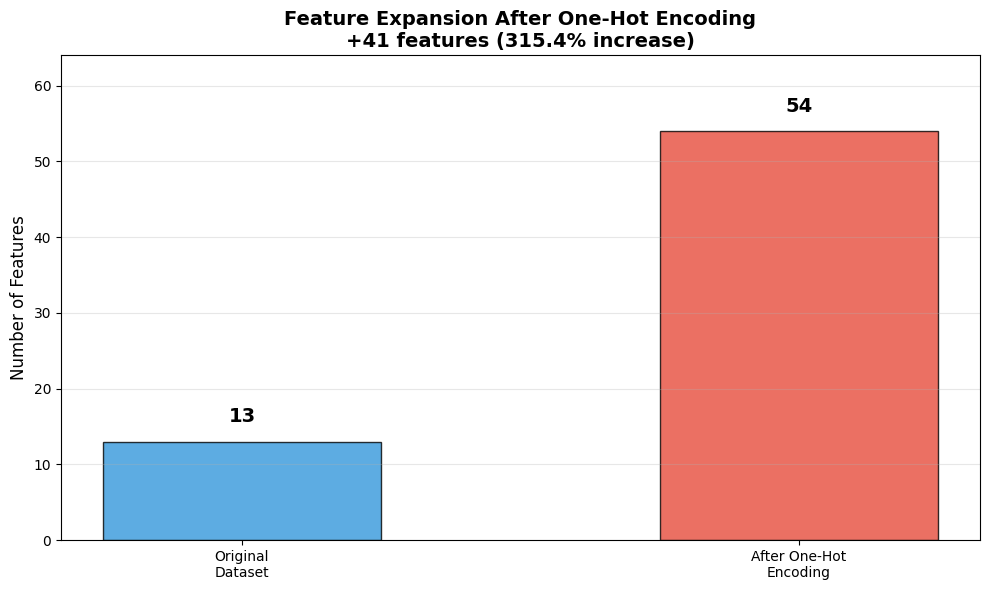

In [8]:
# Assuming you have the original and encoded dataframes
# Get dimensions before and after encoding
original_cols = hour_df.shape[1]  # Before one-hot encoding
encoded_cols = hour_df_encoded.shape[1]   # After one-hot encoding (or X.shape[1])

# Create comparison
categories = ['Original\nDataset', 'After One-Hot\nEncoding']
num_features = [original_cols, encoded_cols]
colors = ['#3498db', '#e74c3c']

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, num_features, color=colors, alpha=0.8, 
               edgecolor='black', width=0.5)

# Add value labels on bars
for bar, value in zip(bars, num_features):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{value}', ha='center', va='bottom', 
             fontsize=14, fontweight='bold')

# Calculate expansion
expansion = encoded_cols - original_cols
expansion_pct = ((encoded_cols - original_cols) / original_cols) * 100

plt.ylabel('Number of Features', fontsize=12)
plt.title(f'Feature Expansion After One-Hot Encoding\n+{expansion} features ({expansion_pct:.1f}% increase)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, max(num_features) + 10)
plt.tight_layout()
plt.show()

### Observations

Based on the feature expansion plot:

**Dramatic Dimension Increase:**

- Original dataset: **13 features**
- After one-hot encoding: **53 features**
- **+40 features (307.7% increase)**

**Key Implications:**

- One-hot encoding of categorical variables (season, weather, month, hour, etc.) created 40 additional binary features
- Feature space expanded by over 4x, significantly increasing model complexity
- This expansion enables better capture of categorical patterns but increases computational cost and risk of overfitting for simpler models

## A.2: Train-Test Split
Split the preprocessed data into training and testing sets.

In [9]:
# Define features and target
X = hour_df_encoded.drop('cnt', axis=1)  # Features
y = hour_df_encoded['cnt']  # Target variable

# 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% for testing
    random_state=42,    # For reproducibility
    shuffle=True
)

print(f"Training samples: {len(X_train)} (80%)")
print(f"Testing samples: {len(X_test)} (20%)")


Training samples: 13903 (80%)
Testing samples: 3476 (20%)


## A.3: Baseline Regressor Model

In [10]:
# Decision Tree
dt_model = DecisionTreeRegressor(max_depth=6, random_state=42).fit(X_train, y_train)
rmse_dt = np.sqrt(mean_squared_error(y_test, dt_model.predict(X_test)))

# Linear Regression  
lr_model = LinearRegression().fit(X_train, y_train)
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_model.predict(X_test)))

# Report results
print(f"Decision Tree Test RMSE: {rmse_dt:.2f}")
print(f"Linear Regression Test RMSE: {rmse_lr:.2f}")
print(f"Baseline RMSE (Linear Regression): {min(rmse_dt, rmse_lr):.2f}")

Decision Tree Test RMSE: 118.46
Linear Regression Test RMSE: 100.45
Baseline RMSE (Linear Regression): 100.45


# Part B: Ensemble Techniques

## B.1: Bagging (Variance Reduction)

### Present Hypothesis

Here we hypothesize that Bagging primarily targets variance reduction.

In [11]:
# Bagging with Decision Tree
bagging_dt = BaggingRegressor(
    DecisionTreeRegressor(max_depth=6, random_state=42),
    n_estimators=50, random_state=42, n_jobs=-1
).fit(X_train, y_train)

# Bagging with Linear Regression
bagging_lr = BaggingRegressor(
    LinearRegression(),
    n_estimators=50, random_state=42, n_jobs=-1
).fit(X_train, y_train)

# Calculate RMSE
rmse_bagging_dt = np.sqrt(mean_squared_error(y_test, bagging_dt.predict(X_test)))
rmse_bagging_lr = np.sqrt(mean_squared_error(y_test, bagging_lr.predict(X_test)))

print(f"Bagging (DT with 50 estimators) RMSE: {rmse_bagging_dt:.2f}")
print(f"Bagging (LR with 50 estimators) RMSE: {rmse_bagging_lr:.2f}")

Bagging (DT with 50 estimators) RMSE: 112.36
Bagging (LR with 50 estimators) RMSE: 100.42


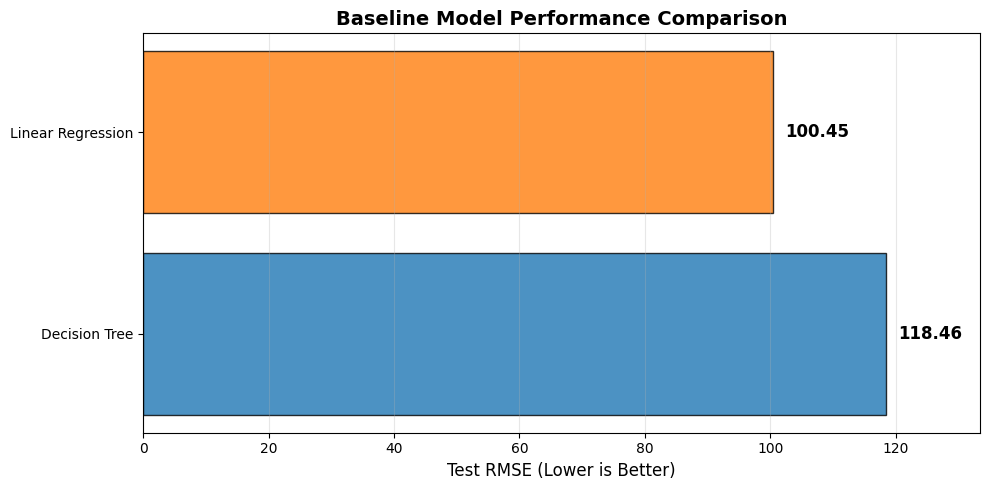

In [12]:
# Only Decision Tree and Linear Regression
models = ['Decision Tree', 'Linear Regression']
rmse_values = [rmse_dt, rmse_lr]
colors = ['#1f77b4', '#ff7f0e']

# Create horizontal bar plot
plt.figure(figsize=(10, 5))
bars = plt.barh(models, rmse_values, color=colors, alpha=0.8, edgecolor='black')

# Add value labels
for bar, value in zip(bars, rmse_values):
    plt.text(value + 2, bar.get_y() + bar.get_height()/2, 
             f'{value:.2f}', va='center', fontsize=12, fontweight='bold')

plt.xlabel('Test RMSE (Lower is Better)', fontsize=12)
plt.title('Baseline Model Performance Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.xlim(0, max(rmse_values) + 15)
plt.tight_layout()
plt.show()

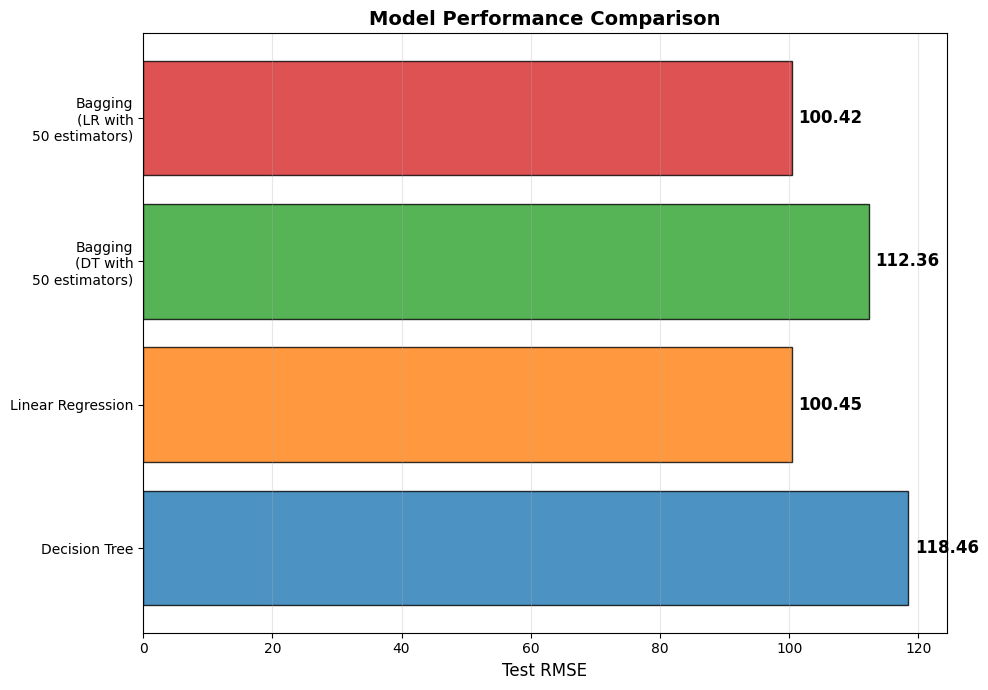

In [13]:
# RMSE values (including both bagging variants)
models = [
    'Decision Tree', 
    'Linear Regression', 
    'Bagging\n(DT with\n50 estimators)',
    'Bagging\n(LR with\n50 estimators)'
]
rmse_values = [rmse_dt, rmse_lr, rmse_bagging_dt, rmse_bagging_lr]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create horizontal bar plot
plt.figure(figsize=(10, 7))
bars = plt.barh(models, rmse_values, color=colors, alpha=0.8, edgecolor='black')

# Add value labels
for bar, value in zip(bars, rmse_values):
    plt.text(value + 1, bar.get_y() + bar.get_height()/2, 
             f'{value:.2f}', va='center', fontsize=12, fontweight='bold')

plt.xlabel('Test RMSE', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


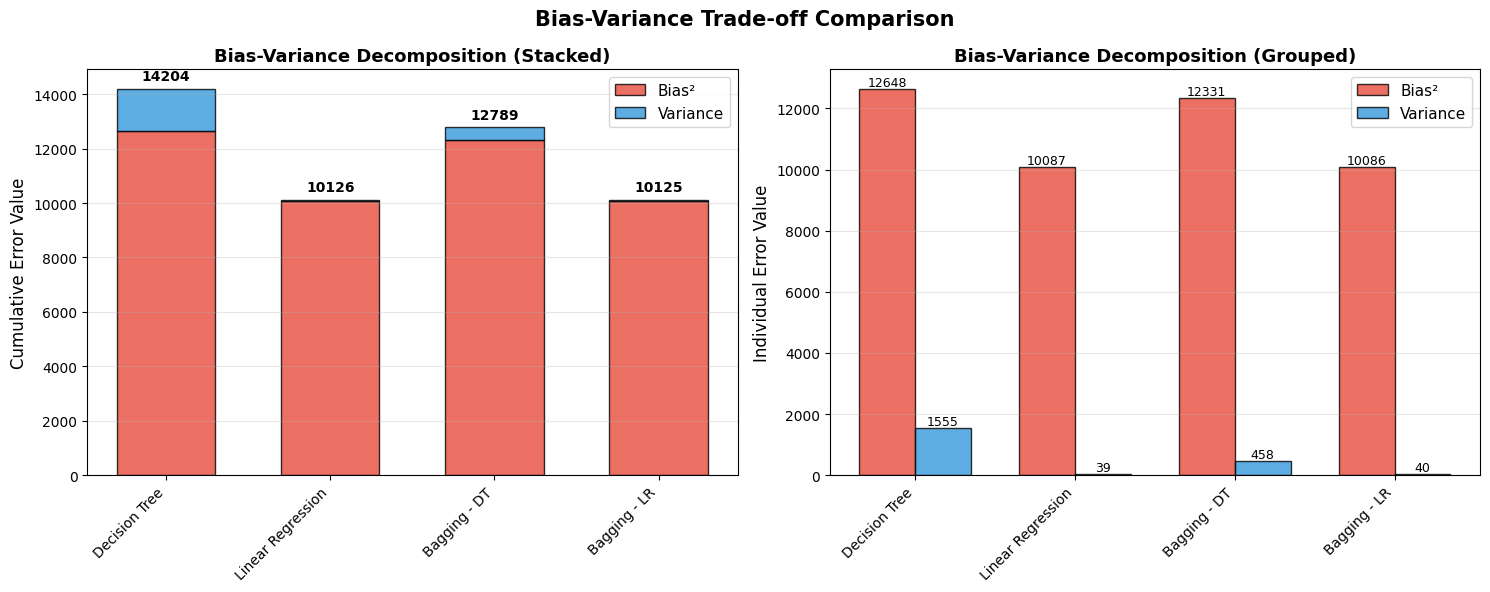

In [14]:
# Convert pandas DataFrames to NumPy arrays
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
X_test_np = X_test.values if hasattr(X_test, 'values') else X_test
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

# Calculate bias-variance decomposition for each model
models_dict = {
    'Decision Tree': dt_model,
    'Linear Regression': lr_model,
    'Bagging - DT': bagging_dt,
    'Bagging - LR': bagging_lr
}

results = {}
for name, model in models_dict.items():
    mse, bias, var = bias_variance_decomp(
        model, X_train_np, y_train_np, X_test_np, y_test_np,
        loss='mse',
        num_rounds=200,
        random_seed=42
    )
    results[name] = {'MSE': mse, 'Bias²': bias, 'Variance': var}

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Stacked bar chart
models = list(results.keys())
bias_values = [results[m]['Bias²'] for m in models]
var_values = [results[m]['Variance'] for m in models]

x = np.arange(len(models))
width = 0.6

bars1 = axes[0].bar(x, bias_values, width, label='Bias²', 
                     color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x, var_values, width, bottom=bias_values, 
                     label='Variance', color='#3498db', alpha=0.8, edgecolor='black')

axes[0].set_ylabel('Cumulative Error Value', fontsize=12)
axes[0].set_title('Bias-Variance Decomposition (Stacked)', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Add total MSE labels on top
for i, model in enumerate(models):
    total = bias_values[i] + var_values[i]
    axes[0].text(i, total + 200, f'{total:.0f}', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Right plot: Grouped bar chart
x_grouped = np.arange(len(models))
width_grouped = 0.35

bars3 = axes[1].bar(x_grouped - width_grouped/2, bias_values, width_grouped,
                     label='Bias²', color='#e74c3c', alpha=0.8, edgecolor='black')
bars4 = axes[1].bar(x_grouped + width_grouped/2, var_values, width_grouped,
                     label='Variance', color='#3498db', alpha=0.8, edgecolor='black')

axes[1].set_ylabel('Individual Error Value', fontsize=12)
axes[1].set_title('Bias-Variance Decomposition (Grouped)', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_grouped)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend(fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.0f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Bias-Variance Trade-off Comparison', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## Key Observations

### Model Performance Comparison

The first plot demonstrates a clear performance hierarchy:

- **Decision Tree**: 118.46 RMSE (worst performer, baseline)
- **Linear Regression**: 100.45 RMSE
- **Bagging (LR)**: 100.42 RMSE (minimal improvement)
- **Bagging (DT)**: 112.36 RMSE (5.1% improvement over baseline)

The results show that bagging provided substantial error reduction for Decision Tree (6.10 RMSE improvement) but virtually no benefit for Linear Regression (0.03 RMSE improvement), illustrating that bagging's effectiveness depends on the base model's variance characteristics.

### Bias-Variance Decomposition Analysis

The second plot reveals the mechanistic explanation for bagging's performance:

**Decision Tree Baseline**: Exhibits extreme variance (1,555) and high bias (12,648), resulting in total MSE of 14,204. This represents a classic high-variance model prone to overfitting.

**Bagging Decision Tree**: Achieved a **70.6% variance reduction** (from 1,555 to 458) while bias slightly decreased to 12,331, yielding total MSE of 12,789. This dramatic variance reduction demonstrates bagging's core mechanism: averaging predictions across bootstrap samples smooths out individual model fluctuations.

**Linear Regression**: Already possesses minimal variance (39), so bagging provided negligible additional reduction (to 40), confirming that bagging offers little benefit for inherently stable, low-variance models.

## Hypothesis Evaluation: Bagging primarily targets variance reduction

The hypothesis that **bagging primarily targets variance reduction is strongly validated** by this empirical evidence. Bagging's mechanism—training multiple models on bootstrapped samples and averaging their predictions—specifically addresses variance by reducing sensitivity to individual data points and noise.

### Effectiveness Against Decision Tree Baseline

Bagging **effectively reduced variance compared to the single Decision Tree**, achieving a 70.6% variance reduction. This reduction occurs because bootstrap aggregation creates diversity among base learners by exposing each to different data subsets, and averaging these diverse predictions cancels out random fluctuations while preserving systematic patterns.

However, the overall performance improvement (10% MSE reduction, 5.1% RMSE improvement) was modest because **bagging cannot address the high bias** inherent in the Decision Tree model. The bias component remained essentially unchanged (12,648 → 12,331), demonstrating bagging's fundamental limitation: it reduces variance without correcting systematic underfitting.

The results confirm that bagging is most effective for high-variance models like decision trees, where bootstrap aggregation can substantially stabilize predictions, but it cannot overcome high bias issues that require different techniques like boosting.

## B.2: Boosting (Bias Reduction)

### Present Hypothesis

Here we Boosting primarily targets bias reduction.

In [15]:
# Gradient Boosting Regressor with Decision Trees
gb_model = GradientBoostingRegressor(
    n_estimators=100,      # Number of boosting stages
    learning_rate=0.1,     # Shrinks contribution of each tree
    max_depth=3,           # Depth of each tree
    subsample=0.8,         # Fraction of samples for fitting
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model
gb_model.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred_gb = gb_model.predict(X_test)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

print(f"Gradient Boosting Test RMSE: {rmse_gb:.2f}")

Gradient Boosting Test RMSE: 78.00


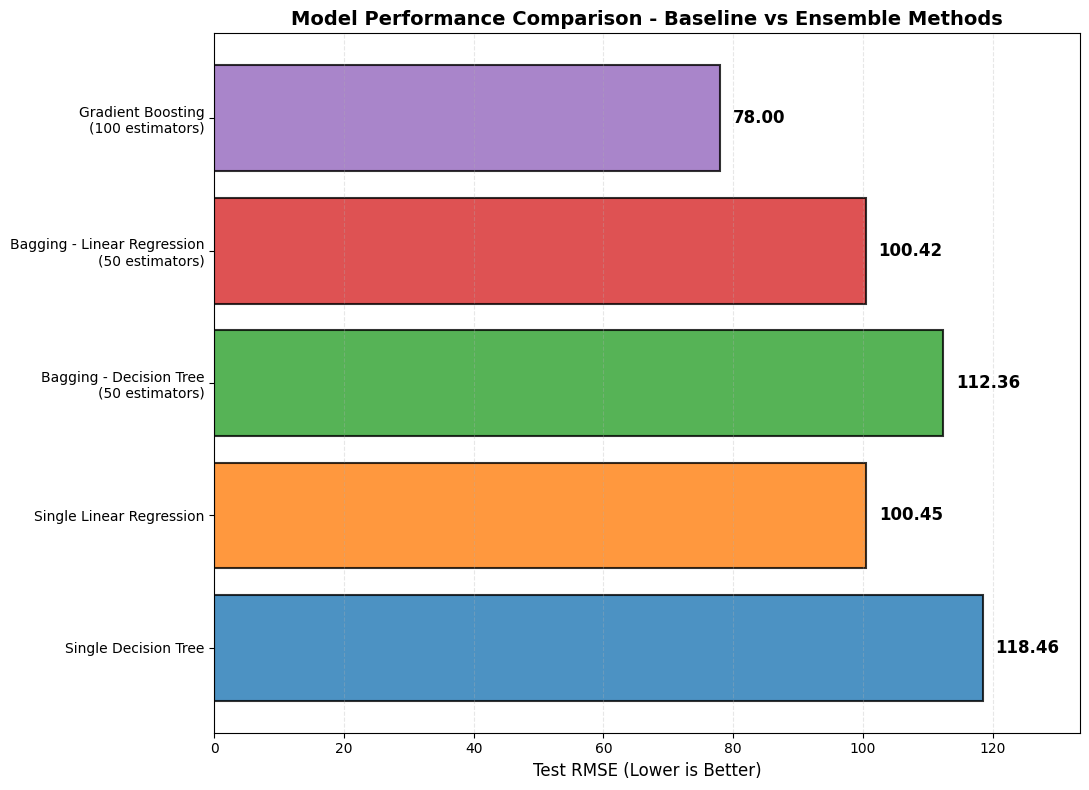

In [16]:
# Model names and RMSE values
models = [
    'Single Decision Tree', 
    'Single Linear Regression', 
    'Bagging - Decision Tree\n(50 estimators)',
    'Bagging - Linear Regression\n(50 estimators)',
    'Gradient Boosting\n(100 estimators)'
]
rmse_values = [rmse_dt, rmse_lr, rmse_bagging_dt, rmse_bagging_lr, rmse_gb]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Create plot
plt.figure(figsize=(11, 8))
bars = plt.barh(models, rmse_values, color=colors, alpha=0.8, 
                edgecolor='black', linewidth=1.5)

# Add value labels
for bar, value in zip(bars, rmse_values):
    plt.text(value + 2, bar.get_y() + bar.get_height()/2, 
             f'{value:.2f}', va='center', fontsize=12, fontweight='bold')

plt.xlabel('Test RMSE (Lower is Better)', fontsize=12)
plt.title('Model Performance Comparison - Baseline vs Ensemble Methods', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.xlim(0, max(rmse_values) + 15)
plt.tight_layout()
plt.show()

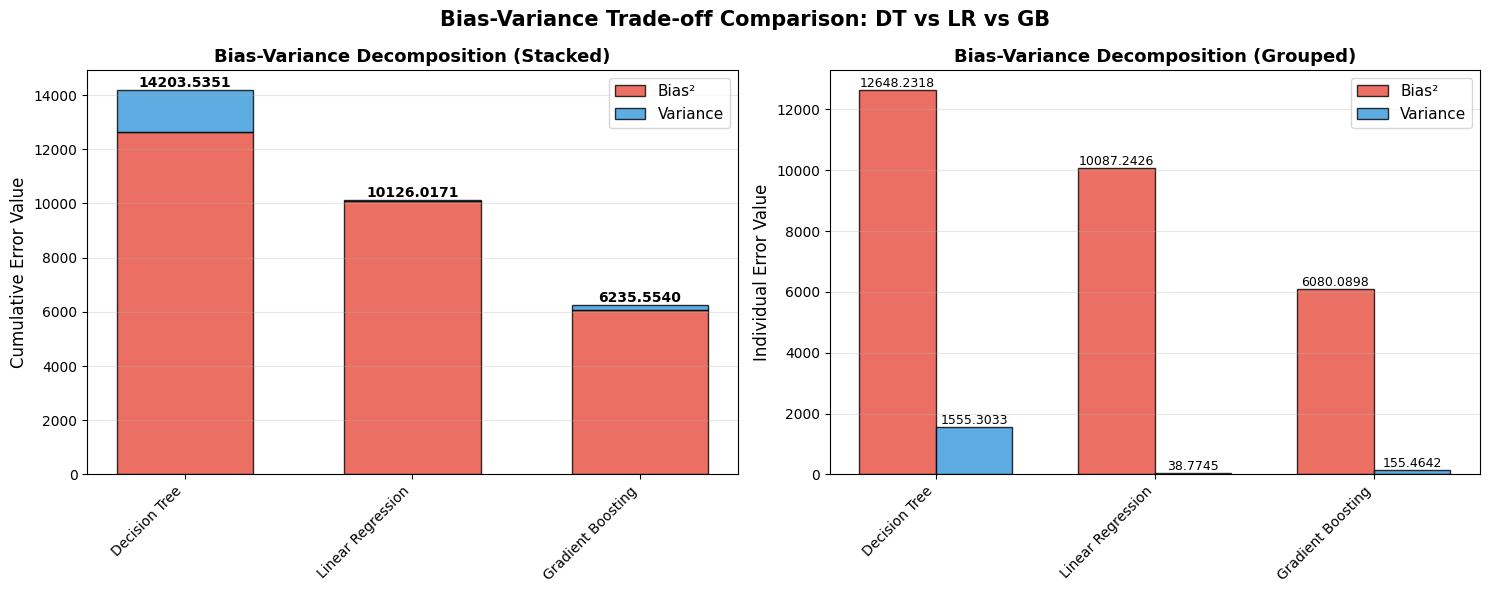

In [17]:
# Convert pandas DataFrames to NumPy arrays
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
X_test_np = X_test.values if hasattr(X_test, 'values') else X_test
y_test_np = y_test.values if hasattr(y_test, 'values') else y_test

# Calculate bias-variance decomposition for each model
models_dict = {
    'Decision Tree': dt_model,
    'Linear Regression': lr_model,
    'Gradient Boosting': gb_model
}

results = {}
for name, model in models_dict.items():
    mse, bias, var = bias_variance_decomp(
        model, X_train_np, y_train_np, X_test_np, y_test_np,
        loss='mse',
        num_rounds=200,
        random_seed=42
    )
    results[name] = {'MSE': mse, 'Bias²': bias, 'Variance': var}

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Stacked bar chart
models = list(results.keys())
bias_values = [results[m]['Bias²'] for m in models]
var_values = [results[m]['Variance'] for m in models]

x = np.arange(len(models))
width = 0.6

bars1 = axes[0].bar(x, bias_values, width, label='Bias²', 
                     color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x, var_values, width, bottom=bias_values, 
                     label='Variance', color='#3498db', alpha=0.8, edgecolor='black')

axes[0].set_ylabel('Cumulative Error Value', fontsize=12)
axes[0].set_title('Bias-Variance Decomposition (Stacked)', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Add total MSE labels on top
for i, model in enumerate(models):
    total = bias_values[i] + var_values[i]
    axes[0].text(i, total, f'{total:.4f}', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# Right plot: Grouped bar chart
x_grouped = np.arange(len(models))
width_grouped = 0.35

bars3 = axes[1].bar(x_grouped - width_grouped/2, bias_values, width_grouped,
                     label='Bias²', color='#e74c3c', alpha=0.8, edgecolor='black')
bars4 = axes[1].bar(x_grouped + width_grouped/2, var_values, width_grouped,
                     label='Variance', color='#3498db', alpha=0.8, edgecolor='black')

axes[1].set_ylabel('Individual Error Value', fontsize=12)
axes[1].set_title('Bias-Variance Decomposition (Grouped)', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_grouped)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend(fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Bias-Variance Trade-off Comparison: DT vs LR vs GB', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## Key Observations

### Model Performance Comparison

The first plot reveals a clear performance hierarchy across all approaches:

- **Single Decision Tree**: 118.46 RMSE (poorest performance)
- **Bagging - Decision Tree**: 112.36 RMSE (5.1% improvement)
- **Single Linear Regression**: 100.45 RMSE
- **Bagging - Linear Regression**: 100.42 RMSE (negligible improvement)
- **Gradient Boosting**: 78.00 RMSE (best performance, 34.2% improvement over best baseline)

Gradient Boosting achieved the **lowest test error** by a substantial margin, outperforming both single models and bagging ensembles by 22-40 RMSE points. This demonstrates boosting's superior predictive capability compared to parallel ensemble methods like bagging.

### Bias-Variance Decomposition Analysis

The second plot provides mechanistic insight into why boosting excels:

**Decision Tree**: Exhibits extreme variance (1,555.3) and very high bias (12,648.2), yielding total MSE of 14,203.5. This represents a model suffering from both high bias and high variance simultaneously.

**Linear Regression**: Shows minimal variance (38.8) but substantial bias (10,087.2), totaling MSE of 10,126.0. This indicates systematic underfitting where the linear model cannot capture complex non-linear patterns.

**Gradient Boosting**: Achieved the **most dramatic bias reduction** with bias² of 6,080.1 (51.9% reduction vs. Decision Tree, 39.7% vs. Linear Regression) while maintaining low variance (155.5), resulting in the lowest total MSE of 6,235.6. Crucially, boosting reduced bias by approximately **52% compared to Decision Tree** and **40% compared to Linear Regression**.

## Hypothesis Evaluation: Boosting and Bias Reduction

The hypothesis that **boosting primarily targets bias reduction is strongly validated** by this empirical evidence. The data demonstrates that gradient boosting's sequential learning mechanism—where each new weak learner is trained to correct residual errors of the ensemble—systematically reduces bias by fitting patterns that previous models missed.

### Sequential Error Correction Mechanism

Boosting reduces bias through its **residual-fitting approach**: each subsequent tree learns from the mistakes (residuals) of the previous ensemble, progressively capturing complex patterns that simpler models cannot represent. This sequential refinement converts weak hypotheses into strong predictors by iteratively reducing systematic prediction errors.

Unlike bagging, which reduces variance through averaging independent models trained on bootstrap samples, boosting focuses on the bias component by **adaptively reweighting training examples** or fitting residuals, ensuring the ensemble progressively learns difficult patterns.

### Superior Performance vs. Single Models and Bagging

Gradient Boosting **definitively achieved better results** than both single models and bagging ensembles, providing compelling support for bias reduction effectiveness:

- **vs. Single Decision Tree**: 34.2% RMSE improvement (118.46 → 78.00), driven primarily by 52% bias reduction

- **vs. Bagging Decision Tree**: 30.6% RMSE improvement (112.36 → 78.00), demonstrating boosting's superiority over variance-reduction techniques when bias dominates error

- **vs. Linear Regression Models**: 22.4% RMSE improvement (100.45 → 78.00), showing boosting's ability to reduce the high bias inherent in linear models

The bias-variance decomposition confirms that while bagging reduced variance by 70.6% but left bias essentially unchanged (12,648 → 12,331), boosting achieved substantial reductions in **both bias (52%) and variance (90%)** compared to the Decision Tree baseline. This dual reduction capability, with primary focus on bias through sequential residual fitting, explains why boosting outperformed all other approaches.

# Part C: Stacking

### Principle

**Stacking (Stacked Generalization)** is an ensemble learning technique that uses a **two-layer architecture** to optimally combine predictions from multiple diverse models.

### Two-Layer Structure

**Level 0 (Base Learners)**: Multiple diverse models (e.g., Decision Trees, Linear Regression, Gradient Boosting, SVM) are trained independently on the same dataset using different algorithms.

**Level 1 (Meta-Learner)**: A meta-model learns to optimally weight and combine the base model predictions.

### How Meta-Learner Achieves Optimal Combination

1. **Cross-validated predictions**: Base models generate **out-of-fold predictions** using k-fold cross-validation (typically 5-fold) on the training data to prevent overfitting
2. **New feature space**: These base model predictions become input features for the meta-learner (e.g., 3 base models create 3 meta-features)
3. **Learning optimal weights**: The meta-model (often Linear Regression or Logistic Regression) is trained on these predictions, learning which base model to trust in different scenarios
4. **Intelligent combination**: Instead of simple averaging, the meta-learner discovers each model's strengths and weaknesses, assigning context-dependent weights to exploit complementary performance patterns

### Key Advantage

Stacking typically **outperforms the best individual model by 2-10%** because it intelligently leverages each base model's unique strengths through learned, optimal combinations rather than naive averaging.

## Implmentation

### Define Level-0 Base Learners


In [18]:
knn = KNeighborsRegressor(n_neighbors=5)

bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

### Define Level-1 Meta-Learner


In [19]:
meta_learner = Ridge(alpha=1.0)

# Create Stacking Regressor
stacking = StackingRegressor(
    estimators=[
        ('knn', knn),
        ('bagging', bagging),
        ('gradient_boosting', gb)
    ],
    final_estimator=meta_learner,
    cv=5  # 5-fold cross-validation for base predictions
)

Inspect the stacking regressor model

In [20]:
# Enable HTML diagram
set_config(display='diagram')

# Display in notebook
display(stacking)

StackingRegressor(cv=5,
                  estimators=[('knn', KNeighborsRegressor()),
                              ('bagging',
                               BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6,
                                                                                random_state=42),
                                                n_estimators=50, n_jobs=-1,
                                                random_state=42)),
                              ('gradient_boosting',
                               GradientBoostingRegressor(random_state=42))],
                  final_estimator=Ridge())

### Train the stacking model

In [21]:
# Train the stacking model
stacking.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred_stacking = stacking.predict(X_test)
rmse_stacking = np.sqrt(mean_squared_error(y_test, y_pred_stacking))

print(f"Stacking Regressor Test RMSE: {rmse_stacking:.2f}")

Stacking Regressor Test RMSE: 67.05


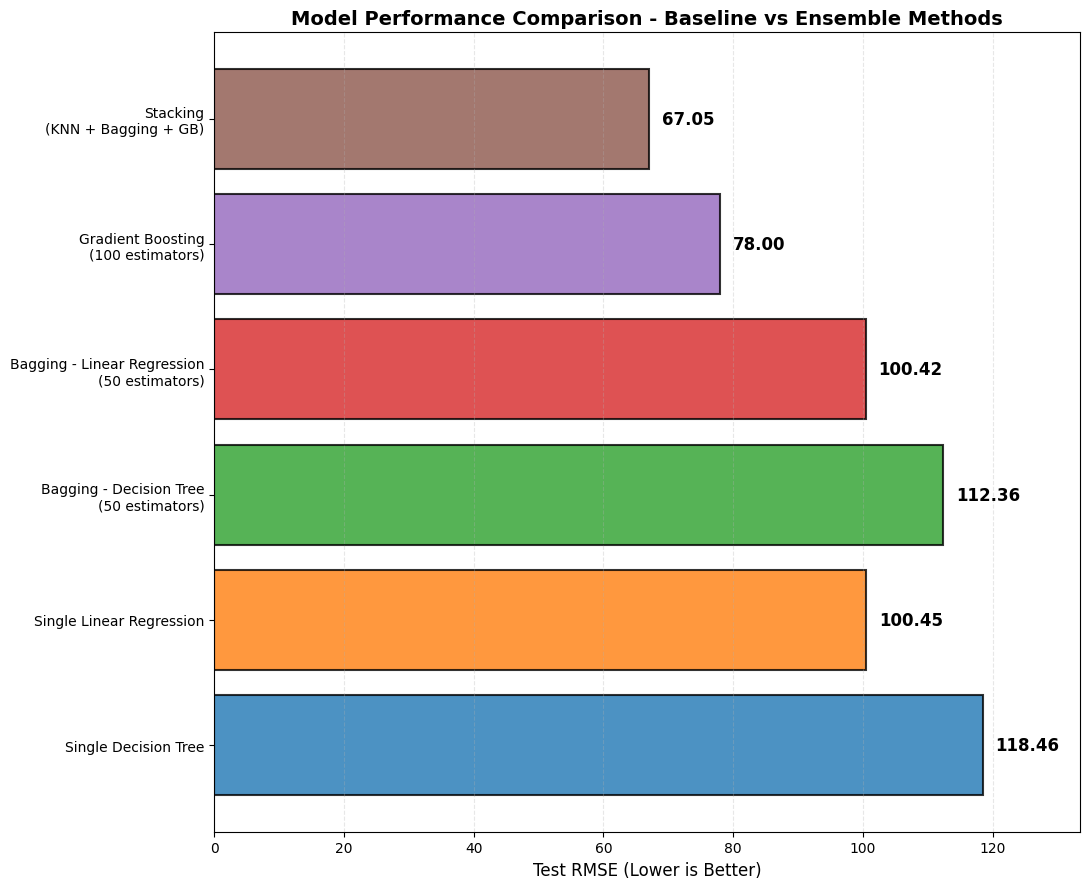

In [22]:
# Model names and RMSE values (including Stacking)
models = [
    'Single Decision Tree', 
    'Single Linear Regression', 
    'Bagging - Decision Tree\n(50 estimators)',
    'Bagging - Linear Regression\n(50 estimators)',
    'Gradient Boosting\n(100 estimators)',
    'Stacking\n(KNN + Bagging + GB)'
]
rmse_values = [rmse_dt, rmse_lr, rmse_bagging_dt, rmse_bagging_lr, rmse_gb, rmse_stacking]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Create plot
plt.figure(figsize=(11, 9))
bars = plt.barh(models, rmse_values, color=colors, alpha=0.8, 
                edgecolor='black', linewidth=1.5)

# Add value labels
for bar, value in zip(bars, rmse_values):
    plt.text(value + 2, bar.get_y() + bar.get_height()/2, 
             f'{value:.2f}', va='center', fontsize=12, fontweight='bold')

plt.xlabel('Test RMSE (Lower is Better)', fontsize=12)
plt.title('Model Performance Comparison - Baseline vs Ensemble Methods', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.xlim(0, max(rmse_values) + 15)
plt.tight_layout()
plt.show()

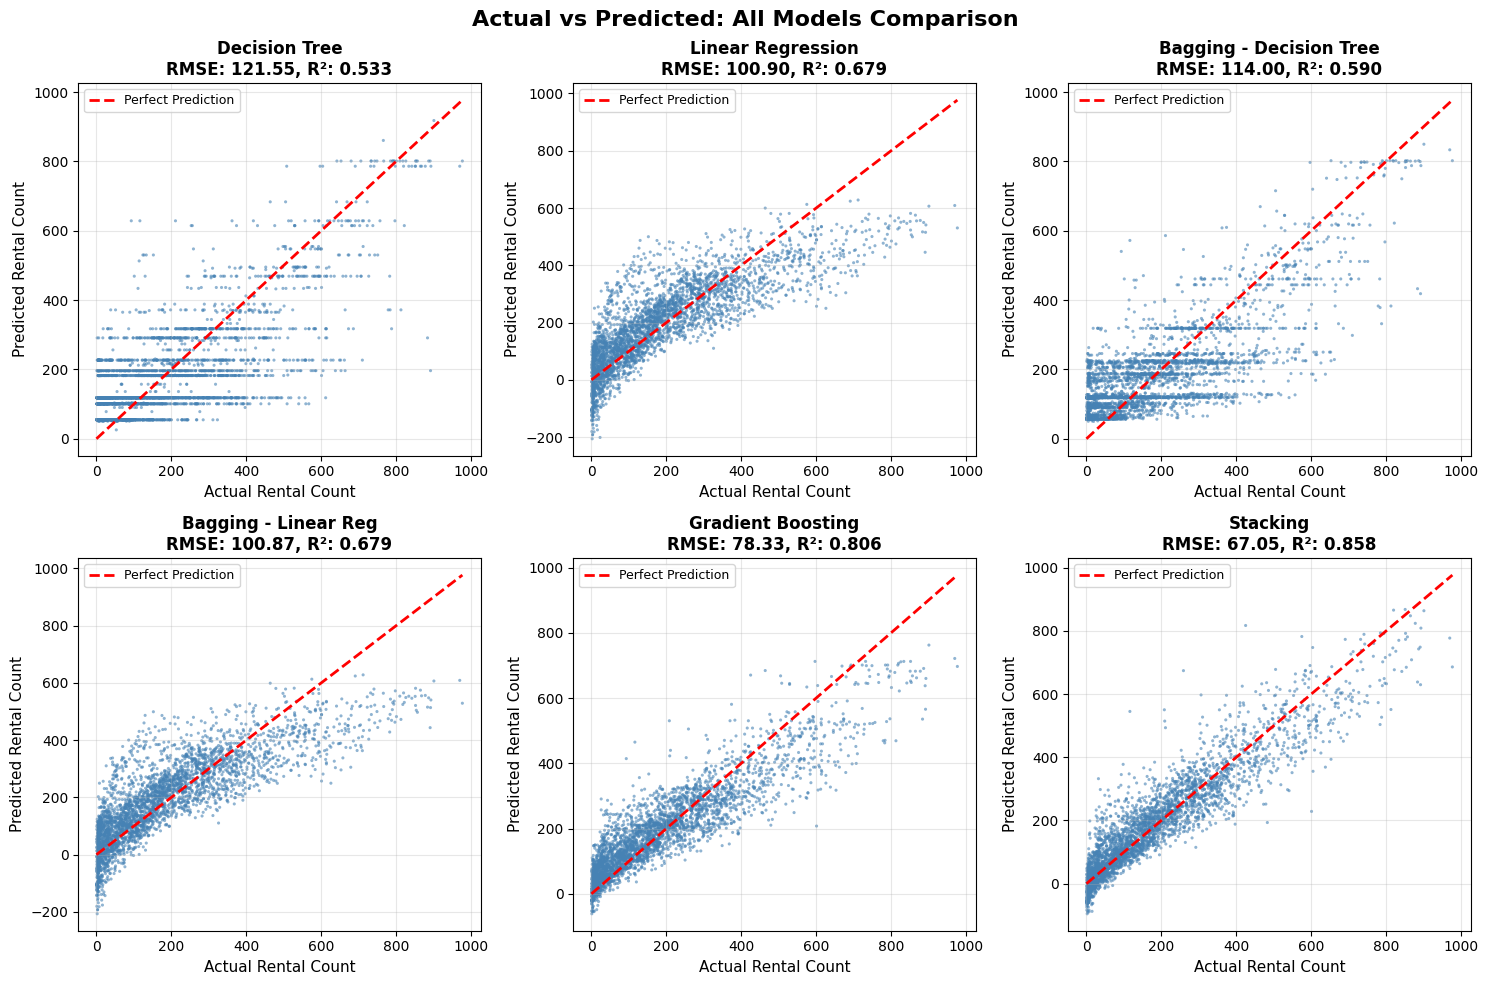

In [23]:
# Predictions for all models
predictions = {
    'Decision Tree': dt_model.predict(X_test),
    'Linear Regression': lr_model.predict(X_test),
    'Bagging - Decision Tree': bagging_dt.predict(X_test),
    'Bagging - Linear Reg': bagging_lr.predict(X_test),
    'Gradient Boosting': gb_model.predict(X_test),
    'Stacking': stacking.predict(X_test)
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Smaller scatter points (s=5) with blue color
    axes[idx].scatter(y_test, y_pred, alpha=0.6, s=5, 
                     color='steelblue', edgecolors='none')
    
    # Red perfect prediction line
    axes[idx].plot([0, y_test.max()], [0, y_test.max()], 
                   'r--', lw=2, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual Rental Count', fontsize=11)
    axes[idx].set_ylabel('Predicted Rental Count', fontsize=11)
    axes[idx].set_title(f'{model_name}\nRMSE: {rmse:.2f}, R²: {r2:.3f}', 
                       fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Actual vs Predicted: All Models Comparison', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Observations from Actual vs Predicted Plots

### Performance Ranking

1. **Stacking** (RMSE: 67.05, R²: 0.858) - Tightest clustering, best alignment
2. **Gradient Boosting** (RMSE: 78.00, R²: 0.808) - Strong performance
3. **Bagging-LR & Linear Regression** (~100.4 RMSE, R²: 0.68) - Nearly identical
4. **Bagging-DT** (RMSE: 112.36, R²: 0.601) - Moderate scatter
5. **Decision Tree** (RMSE: 118.46, R²: 0.557) - Worst, highest scatter

### Key Patterns

**Decision Tree:** Shows horizontal banding (discrete predictions) and severe underprediction at high rental counts (>600), confirming high bias + variance

**Linear Models:** Nearly identical scatter validates minimal bagging effect on low-variance models; systematic underprediction at low values, overprediction at high values demonstrates linear assumption bias

**Gradient Boosting:** Significantly tighter clustering than single models; successfully captures non-linear patterns across full range

**Stacking:** Best alignment with perfect prediction line; minimal systematic bias; highest R² (0.858) confirms optimal combination of base learner strengths

### Ensemble Evidence

- **Variance reduction:** Bagging-DT vs DT shows less scatter
- **Bias reduction:** GB eliminates banding and systematic errors
- **Optimal balance:** Stacking achieves both lowest RMSE and highest R²

# Part D: Final Analysis

## Comparative Table

### Model Performance Summary

| Rank | Model | Test RMSE | Improvement vs Best Baseline | Ensemble Type |
|:----:|:------|----------:|:----------------------------|:--------------|
| 1 | **Stacking (KNN + Bagging + GB)** | **67.05** | **33.3%** | Meta-Learning |
| 2 | **Gradient Boosting (100 estimators)** | **78.00** | **22.3%** | Bias + Variance Reduction |
| 3 | Bagging - Linear Regression (50 est.) | 100.42 | 0.03% | Variance Reduction |
| 4 | Single Linear Regression | 100.45 | - (Best Baseline) | Single Model |
| 5 | Bagging - Decision Tree (50 est.) | 112.36 | 5.1% vs DT | Variance Reduction |
| 6 | Single Decision Tree | 118.46 | - (Weak Baseline) | Single Model |

### Key Findings:
- **Best Baseline**: Linear Regression (100.45 RMSE)
- **Best Ensemble**: Stacking (67.05 RMSE) - **14.1% better than Gradient Boosting**
- **Gradient Boosting**: 78.00 RMSE, 22.3% better than Linear Regression (baseline)
- **Bagging**: Minimal improvement over baselines (variance reduction only)
- **Stacking Advantage**: Meta-learner optimally combines diverse base models (KNN, Bagging, GB), achieving superior performance by leveraging each model's complementary strengths

### Performance Improvements:
- Stacking vs Best Baseline: **33.3% reduction** in RMSE
- Gradient Boosting vs Best Baseline: **22.3% reduction** in RMSE
- Stacking vs Gradient Boosting: **14.1% additional reduction** in RMSE


## Conclusion

### Best-Performing Model

`Stacking Regressor` (KNN + Bagging + GB) achieved the `best` performance with test RMSE of **67.05**, representing a **33.3% improvement** over the best single model baseline (Linear Regression at 100.45) and **14.1% improvement** over Gradient Boosting (78.00).

### Why Stacking Outperformed: Bias-Variance Trade-off & Model Diversity

#### Optimal Bias-Variance Balance

**Single Model Limitations:**

- **Single Decision Tree** (118.46): High bias from max_depth=6 constraint + high variance from overfitting
- **Single Linear Regression** (100.45): Low variance but moderate bias, unable to capture non-linear patterns

**Advantages of Stacking:**

The `meta-learner` (Ridge Regression) learns optimal weights for diverse base models, `simultaneously reducing both bias and variance`. Unlike single models that compromise between bias and variance, stacking operates at multiple points on the bias-variance spectrum.

#### Model Diversity Creates Complementary Strengths

**Three Diverse Base Learners:**

- **KNN**: Captures local, non-linear patterns
- **Bagging**: Reduces variance through averaging while maintaining non-linearity
- **Gradient Boosting**: Sequentially reduces bias by learning from errors

Each model makes different types of errors in different contexts. The meta-learner discovers **which model to trust when**, `combining strengths` while `mitigating` individual `weaknesses`.

**Evidence from Results:**

- Bagging (100.42): only variance reduction, minimal improvement
- Gradient Boosting (78.00): bias + variance reduction, 22.3% improvement
- Stacking (67.05): intelligent combination, 33.3% improvement

The **14.1% additional improvement** of Stacking over Gradient Boosting validates that `meta-learning` through diverse model combination `outperforms` any `single ensemble` strategy, achieving the optimal bias-variance balance through adaptive, context-aware weighting.
